# 卷积层代码实现

### 第1件事：卷积在干什么

```
一个小窗口在图片上滑动
每到一个位置，算一个数
滑完整张图，得到一张新的权重矩阵

```
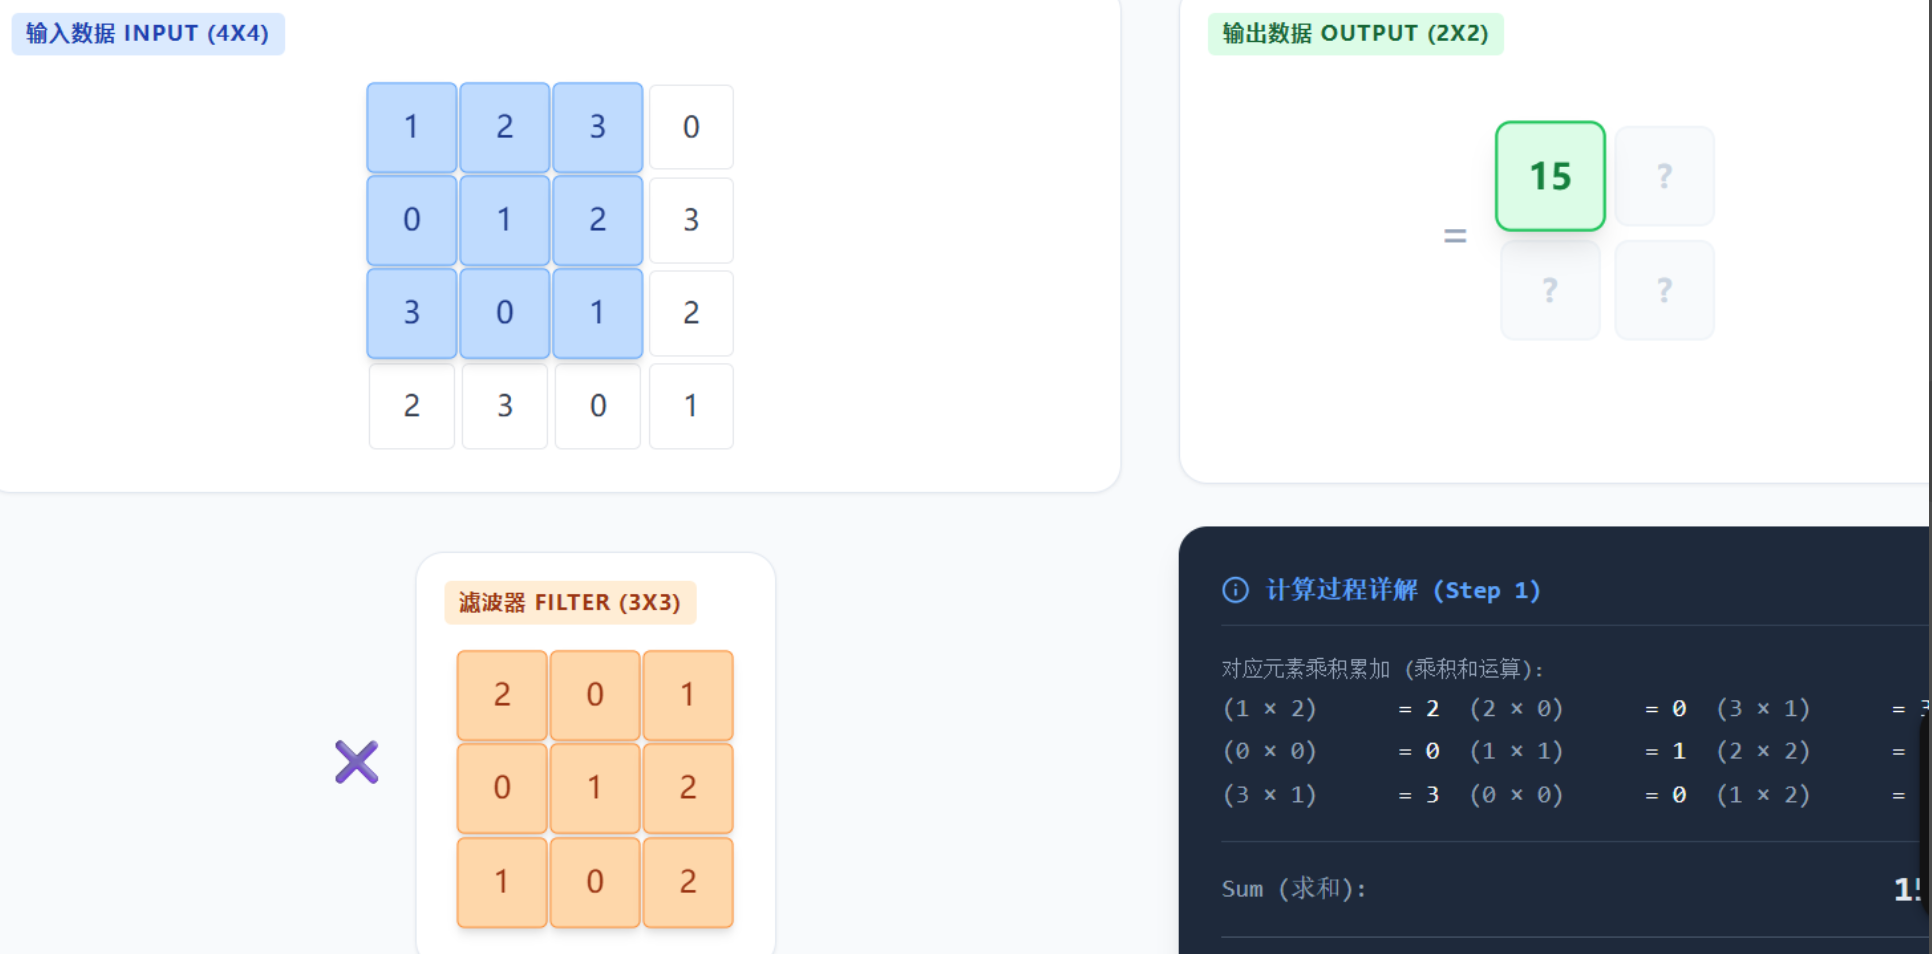
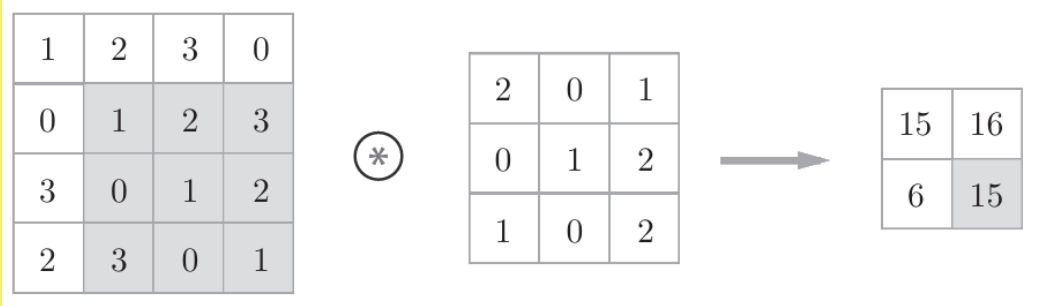

### 第2件事：nn.Conv2d语法

```python
# 创建一个卷积层
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
# 输入通道数=1    输出通道数=1     窗口大小3×3
```

**就像创建nn.Linear一样简单！**

```python
# 对比一下：
nn.Linear(20, 256)                    # 全连接层：20进256出
nn.Conv2d(1, 1, kernel_size=3)        # 卷积层：1通道进，1通道出，3×3的窗口
```

### 第3件事：放到网络里用

```python
net = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3),    # 卷积层
    nn.ReLU(),                          # 激活函数
    nn.Conv2d(1, 1, kernel_size=3),    # 再来一个卷积层
)
```

**和之前学的Sequential用法一模一样！**

---

## 参数到底什么意思？

### nn.Conv2d 只有3个参数你需要关心

```python
nn.Conv2d(in_channels, out_channels, kernel_size)
```

**用快递分拣来比喻：**

```
in_channels  = 进来几条传送带（输入有几个通道）
out_channels = 出去几条传送带（输出要几个通道）  
kernel_size  = 检查员每次看多大一块区域（窗口大小）
```

### 具体例子

```python
# 黑白图片（1个通道），用3×3的窗口，输出1个通道
nn.Conv2d(1, 1, kernel_size=3)

# 彩色图片（3个通道RGB），用3×3的窗口，输出16个通道
nn.Conv2d(3, 16, kernel_size=3)

# 上一层输出16通道，这一层用5×5的窗口，输出32个通道
nn.Conv2d(16, 32, kernel_size=5)
```

**通道数就像这样理解：**

```
输入1个通道 = 黑白照片（只有亮度）
输入3个通道 = 彩色照片（红、绿、蓝）
输出16个通道 = 提取了16种不同的特征
               比如：边缘、角落、纹理、颜色变化...
               每个通道检测一种东西
```

---

## 和nn.Linear对比着记

**你已经会用nn.Linear了对吧？nn.Conv2d几乎一样！**

| | nn.Linear | nn.Conv2d |
|:---|:---|:---|
| **作用** | 处理一维数据 | 处理图片（二维数据） |
| **创建** | `nn.Linear(20, 256)` | `nn.Conv2d(1, 16, 3)` |
| **参数含义** | 输入大小, 输出大小 | 输入通道, 输出通道, 窗口大小 |
| **放进Sequential** | ✅ | ✅ 一模一样 |

---

## 一个完整的对比

### 以前处理普通数据

```python
net = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
X = torch.rand(2, 20)          # 2个样本，20个特征
output = net(X)                 # 输出：2×10
```

### 现在处理图片数据

```python
net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),    # 卷积层
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3),   # 再一个卷积层
)
X = torch.rand(2, 1, 28, 28)   # 2张图片，1个通道，28×28像素
output = net(X)                  # 输出：2×32×24×24
```

**唯一的区别：**

```
Linear的输入：(批量大小, 特征数)           → 2维
Conv2d的输入：(批量大小, 通道数, 高, 宽)   → 4维

为什么4维？因为图片有高和宽两个空间维度
```

---

### 模板

```python
# 处理图片的网络，和之前学的用法一样
net = nn.Sequential(
    nn.Conv2d(输入通道, 输出通道, kernel_size=核大小),
    nn.ReLU(),
    nn.Conv2d(输入通道, 输出通道, kernel_size=核大小),
    nn.ReLU(),
)
```


**卷积层就是图片版的Linear层，会用nn.Linear就会用nn.Conv2d！**

---

## 三、边缘检测的例子

### 3.1 构造一个简单的输入

```python
X = torch.ones(6, 8)       # 6×8的全1矩阵
X[:, 2:6] = 0              # 中间4列设为0
print(X)
```

```
输出：
1  1  0  0  0  0  1  1
1  1  0  0  0  0  1  1
1  1  0  0  0  0  1  1
1  1  0  0  0  0  1  1
1  1  0  0  0  0  1  1
1  1  0  0  0  0  1  1

左边两列是1，中间四列是0，右边两列是1
在第2列和第3列之间有一条"边缘"（从白变黑）
在第5列和第6列之间有一条"边缘"（从黑变白）
```

### 3.2 构造一个边缘检测核

```python
K = torch.tensor([[1.0, -1.0]])    # 1×2的核
```

**这个核为什么能检测边缘？**

```
核是 [1, -1]

当窗口盖住两个相同的像素时：
    [1, 1] × [1, -1] = 1×1 + 1×(-1) = 0    ← 没有边缘
    [0, 0] × [1, -1] = 0×1 + 0×(-1) = 0    ← 没有边缘

当窗口盖住两个不同的像素时：
    [1, 0] × [1, -1] = 1×1 + 0×(-1) = 1    ← 检测到边缘！
    [0, 1] × [1, -1] = 0×1 + 1×(-1) = -1   ← 检测到边缘！

相同 → 输出0（没边缘）
不同 → 输出非0（有边缘！）
```

### 3.3 做卷积

```python
Y = corr2d(X, K)
print(Y)
```

```
输出：
 0   1  0  0  0 -1  0
 0   1  0  0  0 -1  0
 0   1  0  0  0 -1  0
 0   1  0  0  0 -1  0
 0   1  0  0  0 -1  0
 0   1  0  0  0 -1  0

1的那一列 = 从白变黑的边缘
-1的那一列 = 从黑变白的边缘
0 = 没有边缘
```

**卷积成功检测出了竖直方向的边缘！**

---

## 知识总结

### 你需要记住的

```
1. 卷积运算 = 小窗口滑动，对应位置相乘再求和
2. 输出大小 = 输入大小 - 核大小 + 1
3. 卷积核是可学习的参数，不需要手动设计
4. PyTorch的Conv2d输入必须是4维：(批量, 通道, 高, 宽)
```
----

## 代码实现的关键区别：创建层 vs 使用层

### 创建卷积层（不需要reshape）

```python
# 这一步只是造一个"工具"，还没用
conv_layer = nn.Conv2d(
    in_channels=1,        
    out_channels=16,       
    kernel_size=3
)
```

**这一步不涉及数据，所以不需要reshape**

### 使用卷积层（需要4维输入）

```python
# 造好工具后，要拿数据丢进去
X = torch.rand(28, 28)     # ❌ 错！2维数据
output = conv_layer(X)   # 报错！

# 必须先把数据变成4维
X = torch.rand(1, 1, 28, 28)    # ✅ 对！4维
output = conv_layer(X)   # 正常运行
```

---

## 完整流程

```python
# 第1步：创建卷积层（这里不需要reshape）
conv = nn.Conv2d(1, 16, kernel_size=3)

# 第2步：准备数据（这里需要确保是4维！）
X = torch.rand(10, 1, 28, 28)    # 10张图，1通道，28×28
#              ^  ^   ^^   ^^
#              批 通道 高   宽
#              量

# 第3步：数据丢进去
output = conv(X)
print(output.shape)   # torch.Size([10, 16, 26, 26])
```

---

## 什么时候需要reshape？

**当你的原始数据不是4维时：**

```python
# 场景1：单张图片
img = torch.rand(28, 28)             # 2维：高×宽
img = img.reshape(1, 1, 28, 28)      # 改成4维
output = conv(img)

# 场景2：批量图片但没通道维度
imgs = torch.rand(10, 28, 28)        # 3维：批量×高×宽
imgs = imgs.reshape(10, 1, 28, 28)   # 加上通道维度
output = conv(imgs)

# 场景3：已经是4维了，不用改
imgs = torch.rand(10, 1, 28, 28)     # 已经是4维
output = conv(imgs)                   # 直接用
```

---

## 总结成一个清晰的顺序

```python
# ========== 第1步：定义网络 ==========
net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),     # 创建层，不涉及数据
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3),
)

# ========== 第2步：准备数据 ==========
# 原始数据可能是各种形状，需要处理成4维

# 如果数据本来就是4维：
X = torch.rand(10, 1, 28, 28)   # 不用改
output = net(X)

# 如果数据是2维或3维：
X = torch.rand(28, 28)           # 2维
X = X.reshape(1, 1, 28, 28)      # 必须改成4维！
output = net(X)
```

---

## bias要不要的简单答案

```python
# 方案1：不写，用默认（最常见）
nn.Conv2d(1, 16, kernel_size=3)           # bias=True（默认）

# 方案2：明确写True（和上面一样）
nn.Conv2d(1, 16, kernel_size=3, bias=True)

# 方案3：写False（只在特殊情况，现在不用管）
nn.Conv2d(1, 16, kernel_size=3, bias=False)
```

**你现在就用方案1，不写bias，让它默认就行！**

---

## 模板

```python
# 创建网络
net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),    # 输入1通道，输出16通道，3×3核
    nn.ReLU(),
)

# 准备数据：必须是4维！
X = torch.rand(10, 1, 28, 28)     
#              批 通道 高  宽
# 如果不是4维，用reshape改成4维

# 使用
output = net(X)
```
